In [5]:
import numpy as np
import scipy as sp
import seaborn as sn
import matplotlib.pylab as pl
%matplotlib inline

import os 
os.chdir('../src/')

from EDFOperator import EDFOperator
from HDFEyeOperator import HDFEyeOperator
from EyeSignalOperator import EyeSignalOperator

os.chdir('../test/')

sn.set(style="ticks")

ImportError: No module named 'FIRDeconvolution'

In [8]:
edf_file = 'tk_1_2014-10-06_16.44.11.edf'
# edf_file = 'adsfg.edf'

low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01
alias = 'test_1'

# initialize the hdfeyeoperator
ho = HDFEyeOperator('test.h5')
# insert the edf file contents only when the h5 is not present.
if not os.path.isfile('test.h5'):
    ho.add_edf_file(edf_file)
    ho.edf_message_data_to_hdf(alias = alias)
    ho.edf_gaze_data_to_hdf(alias = alias, pupil_hp = high_pass_pupil_f, pupil_lp = low_pass_pupil_f)

In [9]:
trial_times
trial_phase_times

trial_phase_trial  trial_phase_EL_timestamp  trial_phase_index  \
0                   0                   5716598                  1   
1                   0                   5717610                  2   
2                   1                   5729277                  1   
3                   1                   5730287                  2   
4                   2                   5740484                  1   
5                   2                   5741494                  2   
6                   3                   5753086                  1   
7                   3                   5754096                  2   
8                   4                   5768669                  1   
9                   4                   5769680                  2   
10                  5                   5781197                  1   
11                  5                   5782208                  2   
12                  6                   5792885                  1   
13                  6                   5793895                  2   
14                  7                   5806198                  1   
15                  7                   5807208                  2   

    trial_phase_exp_timestamp  
0                      4737.1  
1                      4738.1  
2                      4749.7  
3                      4750.7  
4                      4760.9  
5                      4762.0  
6                      4773.5  
7                      4774.6  
8                      4789.1  
9                      4790.1  
10                     4801.7  
11                     4802.7  
12                     4813.3  
13                     4814.4  
14                     4826.7  
15                     4827.7

In [10]:
# downsample for plotting
downsample_rate = 10

# load times per session:
trial_times = ho.read_session_data(alias, 'trials')
trial_phase_times = ho.read_session_data(alias, 'trial_phases')

# check at what timestamps the recording started:
session_start_EL_time = np.array( trial_phase_times[np.array(trial_phase_times['trial_phase_index'] == 1) * np.array(trial_phase_times['trial_phase_trial'] == 0)]['trial_phase_EL_timestamp'] )[0]
session_stop_EL_time = np.array(trial_times['trial_end_EL_timestamp'])[-1]

# and, find some aspects of the recording such as sample rate and recorded eye
sample_rate = ho.sample_rate_during_period([session_start_EL_time, session_stop_EL_time], alias)
eye = ho.eye_during_period([session_start_EL_time, session_stop_EL_time], alias)
if len(eye) > 0:
    eye = ['L','R'][0]

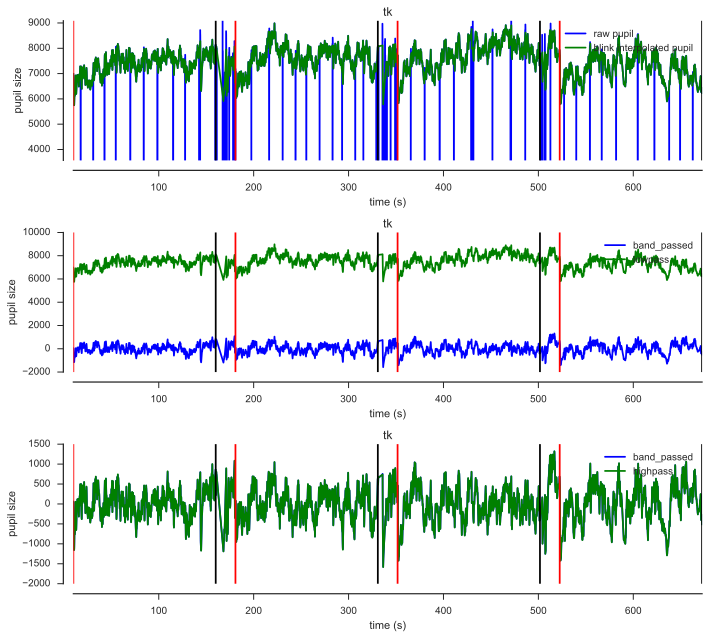

In [11]:
#
# plot some of the pupil signal's processing steps
#

pupil_raw = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil', requested_eye = eye))
pupil_int = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_int', requested_eye = eye))

pupil_bp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_bp', requested_eye = eye))
pupil_lp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_lp', requested_eye = eye))
pupil_hp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_hp', requested_eye = eye))

x = sp.signal.decimate(np.arange(len(pupil_raw)) / float(sample_rate), downsample_rate, 1)
pup_raw_dec = sp.signal.decimate(pupil_raw, downsample_rate, 1)
pup_int_dec = sp.signal.decimate(pupil_int, downsample_rate, 1)

pupil_bp_dec = sp.signal.decimate(pupil_bp, downsample_rate, 1)
pupil_lp_dec = sp.signal.decimate(pupil_lp, downsample_rate, 1)
pupil_hp_dec = sp.signal.decimate(pupil_hp, downsample_rate, 1)

# plot interpolated pupil:
fig = pl.figure(figsize = (10,9))
s = fig.add_subplot(311)
pl.plot(x, pup_raw_dec, 'b'); pl.plot(x, pup_int_dec, 'g')
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['raw pupil', 'blink interpolated pupil'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))
sn.despine(offset=10)

s = fig.add_subplot(312)
pl.plot(x, pupil_bp_dec, 'b'); pl.plot(x, pupil_lp_dec, 'g');
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['band_passed', 'lowpass'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
# s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))
sn.despine(offset=10)

s = fig.add_subplot(313)
pl.plot(x, pupil_bp_dec, 'b'); pl.plot(x, pupil_hp_dec, 'g');
pl.ylabel('pupil size'); pl.xlabel('time (s)')
pl.legend(['band_passed', 'highpass'])
s.set_title('tk')

ymin = pupil_raw.min(); ymax = pupil_raw.max()
tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
for i in range(tps[0].shape[0]):
    pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'r')
    pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
# s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
s.set_xlim(xmin = tps[0][0] / float(sample_rate), xmax = tps[1][-1] / float(sample_rate))
sn.despine(offset=10)
pl.tight_layout()


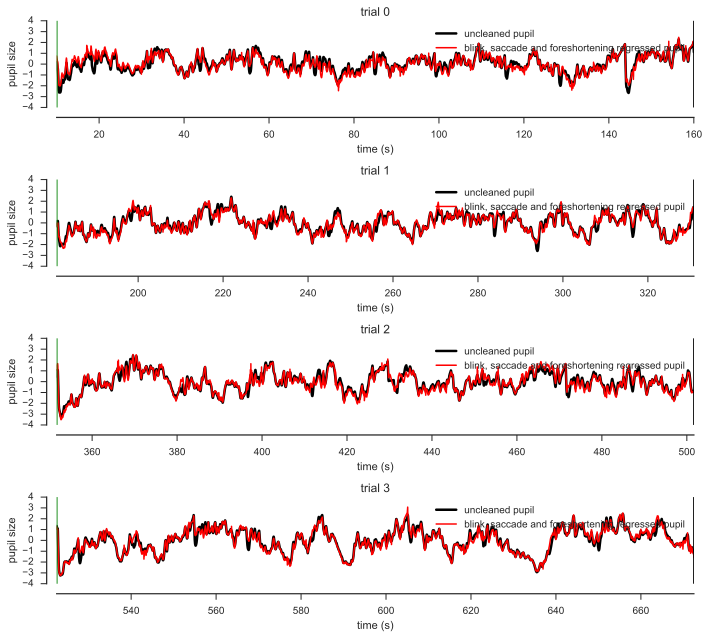

In [12]:
#
# plot the 'regress blinks' processing step, 
# which estimates the effects of blinks, saccades and foreshortening on the data
# and regresses these effects out.
#

pupil_bp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_bp_zscore', requested_eye = eye))
pupil_bp_c = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_bp_clean_zscore', requested_eye = eye))

x = sp.signal.decimate(np.arange(len(pupil_bp)) / float(sample_rate), downsample_rate, 1)
pupil_bp_dec = sp.signal.decimate(pupil_bp, downsample_rate, 1)
pupil_bp_c_dec = sp.signal.decimate(pupil_bp_c, downsample_rate, 1)


# plot interpolated pupil:
fig = pl.figure(figsize = (10,9))
for trial in range(4):# loop across trials
    s = fig.add_subplot(4,1,trial+1)
    s.set_title('trial %i'%trial)
    pl.plot(x, pupil_bp_dec, 'k', lw = 2.5)
    pl.plot(x, pupil_bp_c_dec, 'r', lw = 1.5)
    pl.ylabel('pupil size'); pl.xlabel('time (s)')
    pl.legend(['uncleaned pupil', 'blink, saccade and foreshortening regressed pupil'])

    ymin = pupil_bp.min(); ymax = pupil_bp.max()
    tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
    for i in range(tps[0].shape[0]):
        pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'g')
        pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
    # s.set_ylim(ymin = pup_int_dec.min()-100, ymax = pup_int_dec.max()+100)
    s.set_xlim(xmin = tps[0][trial] / float(sample_rate), xmax = tps[-1][trial] / float(sample_rate))
    sn.despine(offset=10)
pl.tight_layout()

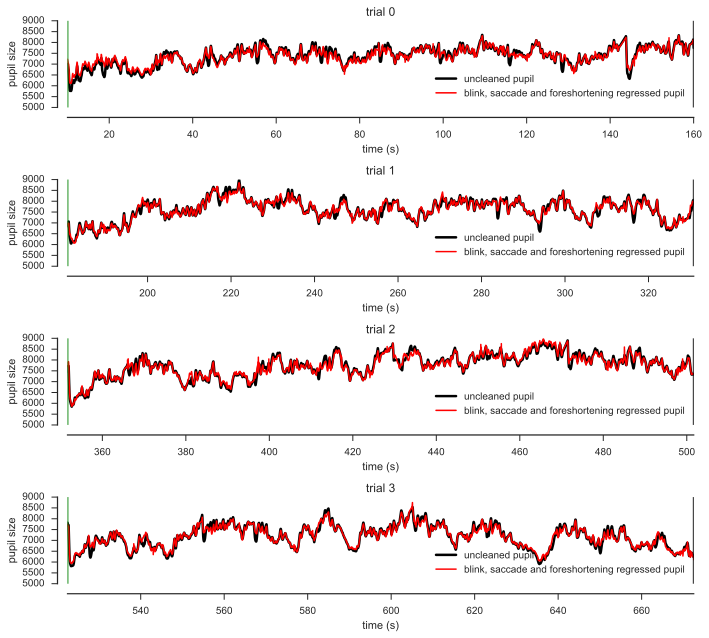

In [13]:
#
# plot the 'regress blinks' processing step, 
# which estimates the effects of blinks, saccades and foreshortening on the data
# and regresses these effects out.
#

pupil_lp = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_lp', requested_eye = eye))
pupil_lp_c = np.squeeze(ho.signal_during_period(time_period = [session_start_EL_time, session_stop_EL_time], alias = alias, signal = 'pupil_lp_clean', requested_eye = eye))

x = sp.signal.decimate(np.arange(len(pupil_lp)) / float(sample_rate), downsample_rate, 1)
pupil_lp_dec = sp.signal.decimate(pupil_lp, downsample_rate, 1)
pupil_lp_c_dec = sp.signal.decimate(pupil_lp_c, downsample_rate, 1)


# plot interpolated pupil:
fig = pl.figure(figsize = (10,9))
for trial in range(4):# loop across trials
    s = fig.add_subplot(4,1,trial+1)
    s.set_title('trial %i'%trial)
    pl.plot(x, pupil_lp_dec, 'k', lw = 2.5)
    pl.plot(x, pupil_lp_c_dec, 'r', lw = 1.5)
    pl.ylabel('pupil size'); pl.xlabel('time (s)')
    pl.legend(['uncleaned pupil', 'blink, saccade and foreshortening regressed pupil'], loc= 4)

    ymin = pupil_bp.min(); ymax = pupil_bp.max()
    tps = (list(trial_phase_times[trial_phase_times['trial_phase_index'] == 2]['trial_phase_EL_timestamp']) - session_start_EL_time, list(trial_phase_times[trial_phase_times['trial_phase_index'] == 3]['trial_phase_EL_timestamp']) - session_start_EL_time)
    for i in range(tps[0].shape[0]):
        pl.axvline(x = tps[0][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'g')
        pl.axvline(x = tps[1][i] / float(sample_rate), ymin = ymin, ymax = ymax, color = 'k')
    s.set_ylim(ymin = 5000, ymax = 9000)
    s.set_xlim(xmin = tps[0][trial] / float(sample_rate), xmax = tps[-1][trial] / float(sample_rate))
    sn.despine(offset=10)
pl.tight_layout()